# Classification of bank clients by probability of opening a deposit

In [66]:
import pandas as pd
import numpy as np

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

# Models and metrics
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 

# Data optimization
from sklearn.preprocessing  import LabelEncoder, MinMaxScaler 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
import optuna

# Visualization
from rich import print
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

## Part 1. Data exploring, processing missing data and outliers

In [67]:
df = pd.read_csv("Data/bank_fin.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [68]:
# Explore the dataset for missing values
df.info()

print("[purple]Looking at missing values")
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Looking at missing values

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [69]:
# Are there any missing values in the job feature? 
df["job"].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [70]:
# Transform the balance feature so it would be correctly read as a real number(float)
def balance_fix(arg):
    ''' Correct values of feature balance'''
    
    if type(arg) is not float: 
        arg = arg.replace("$","")\
                 .replace(",",".")\
                 .replace(" ","")
    return float(arg)

df["balance"] = df["balance"].apply(balance_fix)

In [71]:
# Process the missing values in the balance feature, replacing them with the median
balance_median = round(df["balance"].median(), 3)
df["balance"] = df["balance"].fillna(balance_median)


In [72]:
# Process the missing values in categorical features: job and education, replacing them with modes
df.loc[df["job"]=="unknown", "job"] = df["job"].mode()[0]
df.loc[df["education"]=="unknown", "education"] = df["education"].mode()[0]

In [73]:
# Remove all outliers for the balance feature
def outliers_iqr(data, feature, left=1.5, right=1.5):
    ''' 
        Removing outliers according to Tukey's method 
        
        data[DataFrame]: dataframe with target feature
        feature[str]: target feature
        left[float]: left interval
        right[float]: right interval
        
        return: lower_bound[float]
                upper_bound[float]
                outliers[DataFrame]
                df_cleaned[DataFrame]
    '''

    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr*left)
    upper_bound = quartile_3 + (iqr*right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x <= upper_bound)]
    return lower_bound, upper_bound, outliers, cleaned


lower_bound, upper_bound, outliers, df_cleaned = outliers_iqr(df, "balance")

print(f"[purple]lower_bound: [green]{lower_bound}")
print(f"[purple]upper_bound: [green]{upper_bound}")
print(f"[purple]cleaned data shape: [green]{df_cleaned.shape}")

# Save cleaned dataframe
df = df_cleaned.reset_index(drop=True)

lower_bound: -2241.0

upper_bound: 4063.0

cleaned data shape: (10105, 17)

## Part 2:  Exploratory Data Analysis

<AxesSubplot:xlabel='deposit', ylabel='count'>

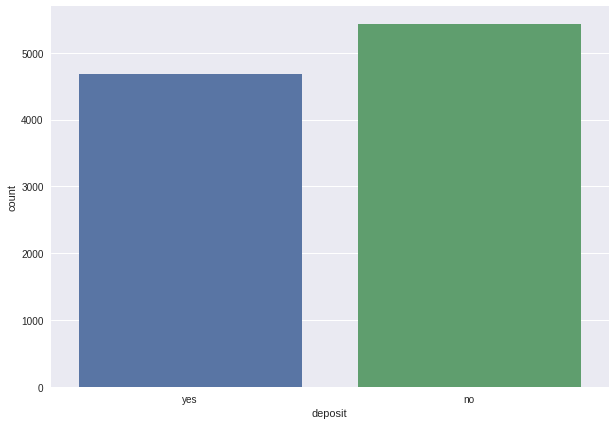

In [74]:
# Examine the class balance in dataset, illustrate the result
fig, ax = plt.subplots(figsize=(10, 7)) 
sns.countplot(data=df, x="deposit", ax=ax)

In [75]:
# Calculate descriptive statistics for quantitative variables
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


<Figure size 576x396 with 0 Axes>

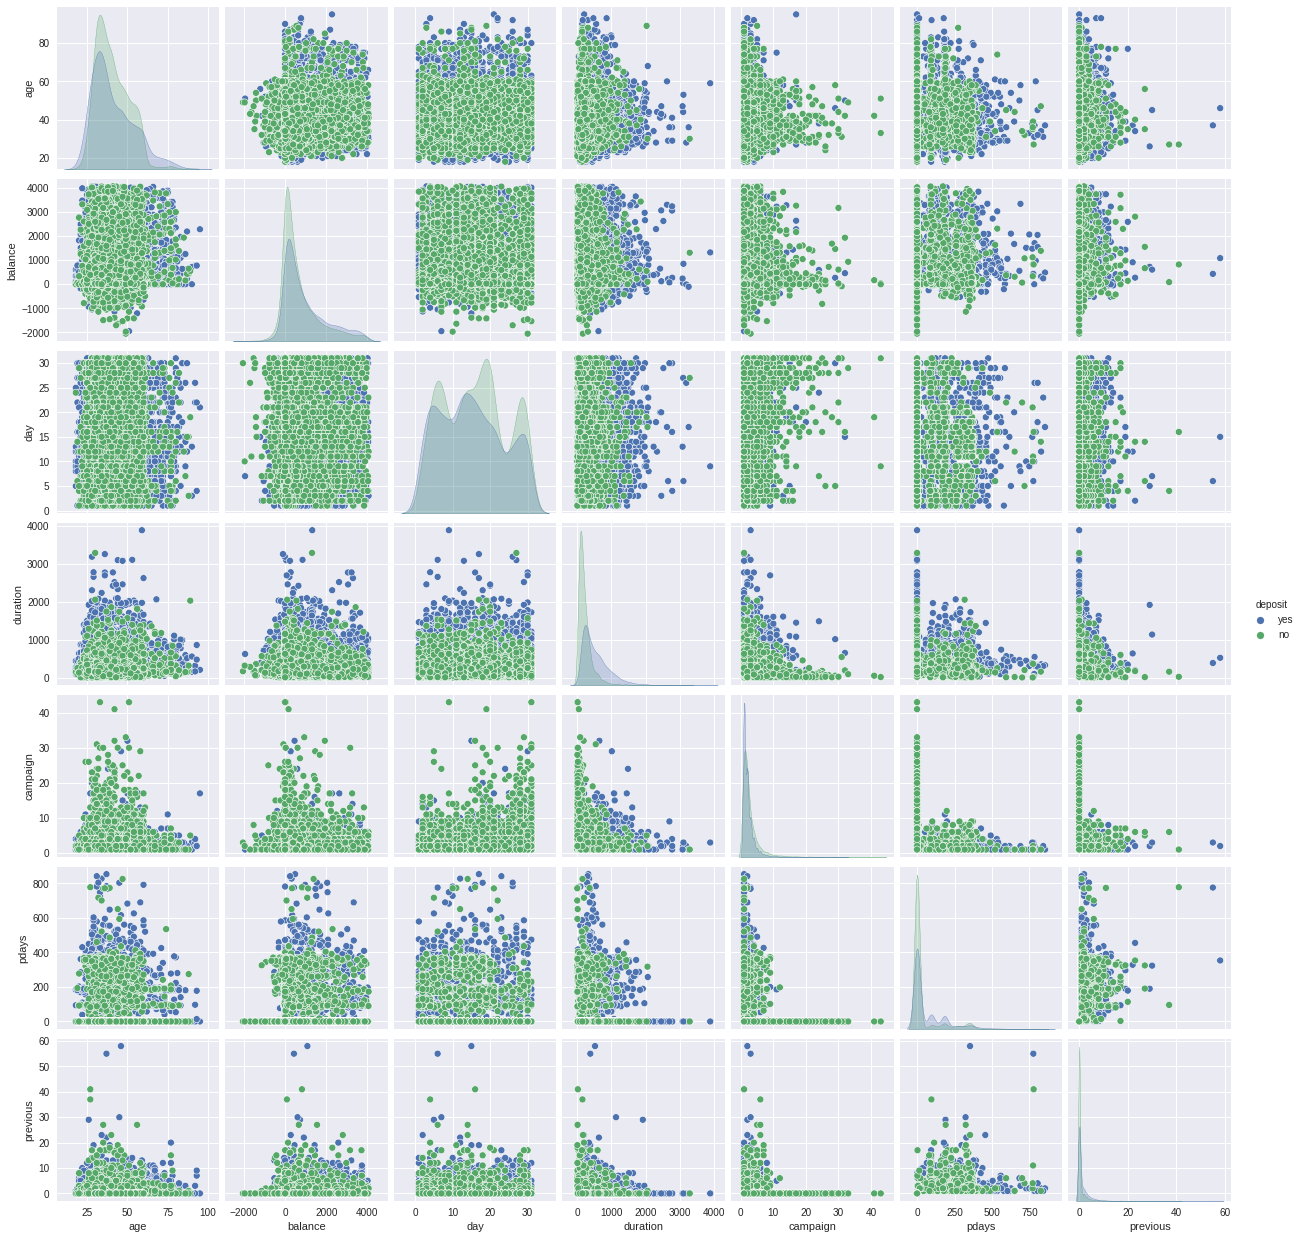

In [76]:
# Plotting distributions of quantitative features 
num_features = ["age", "balance", "day", "duration", "campaign", "pdays", "previous", "deposit"]
plt.figure()
num_plot = sns.pairplot(df[num_features], hue="deposit")
plt.show()

Some conclusions about quantitative features distributions:
- Clients with deposits are under 25 or above 60 years 
- Clients with deposits have longer duration of contacts in their groups
- Clients with zero or near balance have longer duration and higher number of contacts(campaign)
- The distributions of age and balance are log-normal

In [77]:
# Calculate descriptive statistics for categorical variables
df.describe(include="object")

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


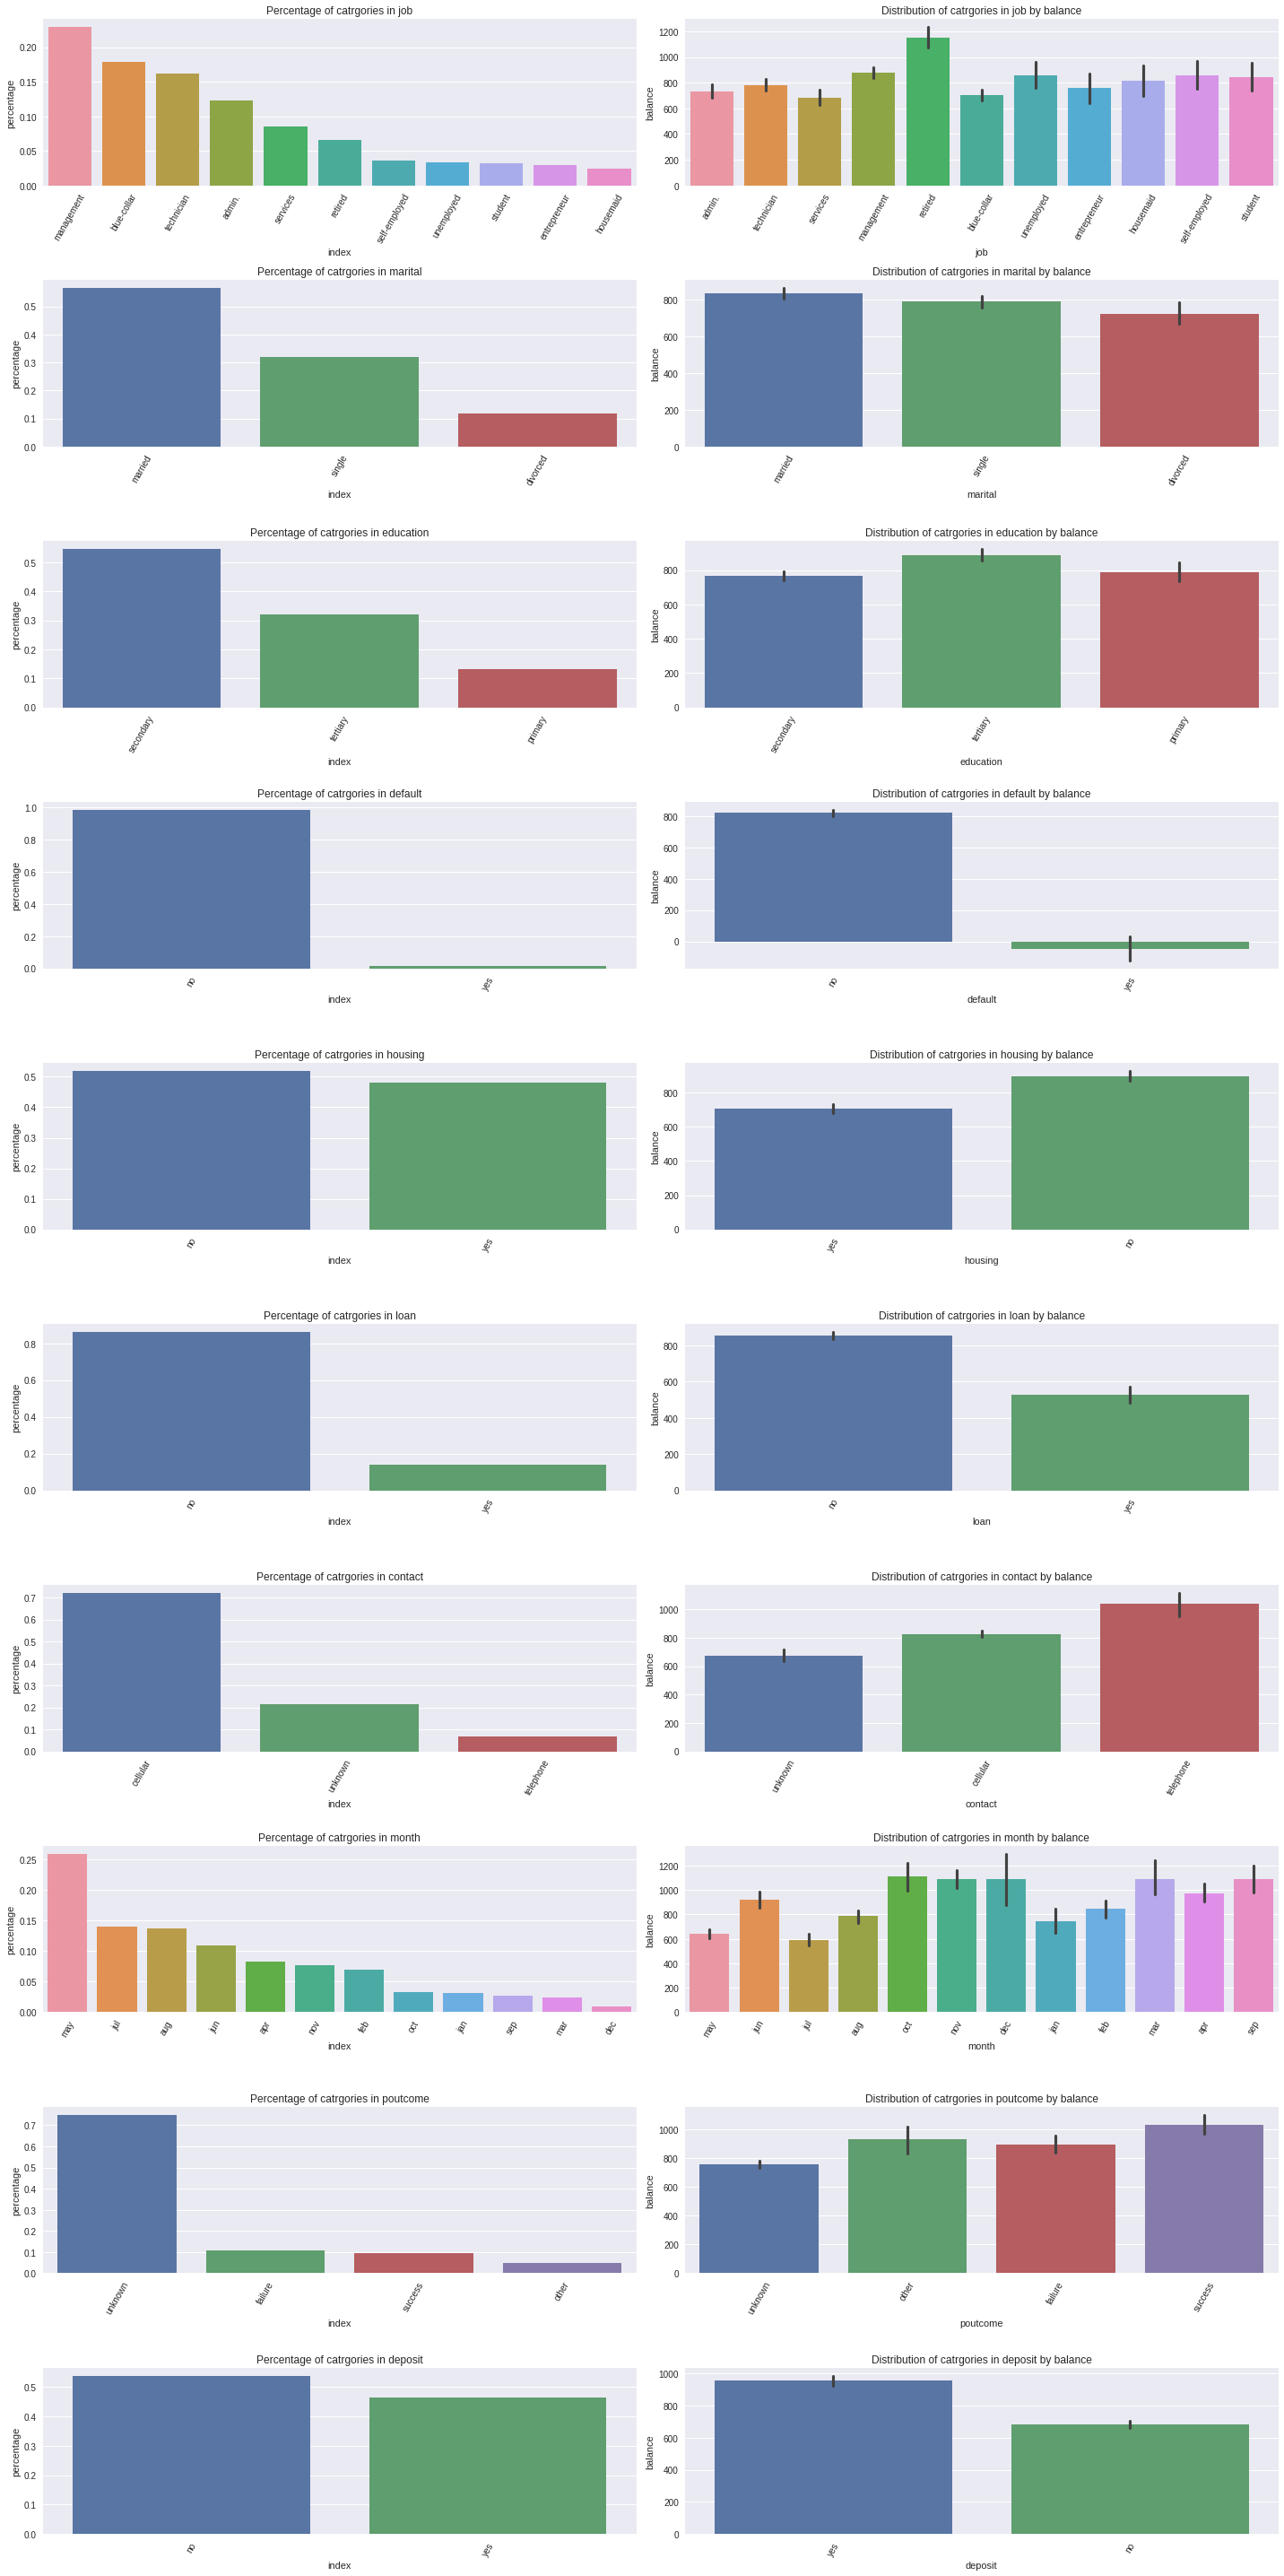

In [78]:
# Plotting distributions of categorical features 
# Create list with categorical columns
types = df.dtypes
cat_features = list(types[(types == "object")].index)

n = len(cat_features)  # number of categrical features
fig, axes = plt.subplots(n, 2, figsize=(20, 40)) 

# Create cycle for all features from cat_features list
for i, feature in enumerate(cat_features):
    # Create quantitative barplots for percentage of each category in feature 
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename("percentage")
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x="index", y="percentage", ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    count_barplot.set_title(f"Percentage of catrgories in {feature}")
    
    # Create barplots with distribution of categories in features by balance 
    mean_barplot = sns.barplot(data=df, x=feature, y="balance", ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
    mean_barplot.set_title(f"Distribution of catrgories in {feature} by balance")
plt.tight_layout()  # plot alignment

Some conclusions about categorical features distribution:
- The biggest category in job feature is management, the highest balance in retired category
- The biggest category in marital feature is married
- Clients mostly has secondary education
- Only 2% of clients have overdue loans
- 48% of clients have home loans
- 48% of clients have loans for personal needs
- 70% of clients used cellular phones for contacting, but the highest balance is for landline phone users
- The most number(25%) of contacts with clients was in may
- The highest balance have clients, who gave positive result on previous marketing campaign
- 55% of clients don't have deposit


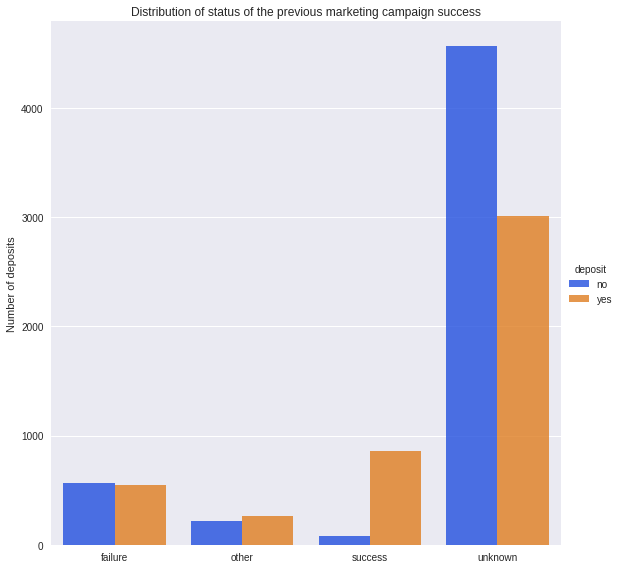

In [79]:
# Find out for which status of the previous marketing campaign success in the current one prevails over the number of failures
df_grpd_poutcome = df[[
                    "poutcome", "deposit"
                    ]].groupby("poutcome"
                              ).value_counts().reset_index().rename(
                                                    columns={0:"dep_count"})

poutcome_plot = sns.catplot(
                        data=df_grpd_poutcome, 
                        kind="bar", 
                        x="poutcome", 
                        y="dep_count", 
                        hue="deposit", 
                        palette="bright", 
                        alpha=.8, 
                        height=8,
)
poutcome_plot.set(title="Distribution of status of the previous marketing campaign success")
poutcome_plot.set_axis_labels("", "Number of deposits")

The previous marketing campaign success in the current one prevails over the number of failures with status: **"success"**

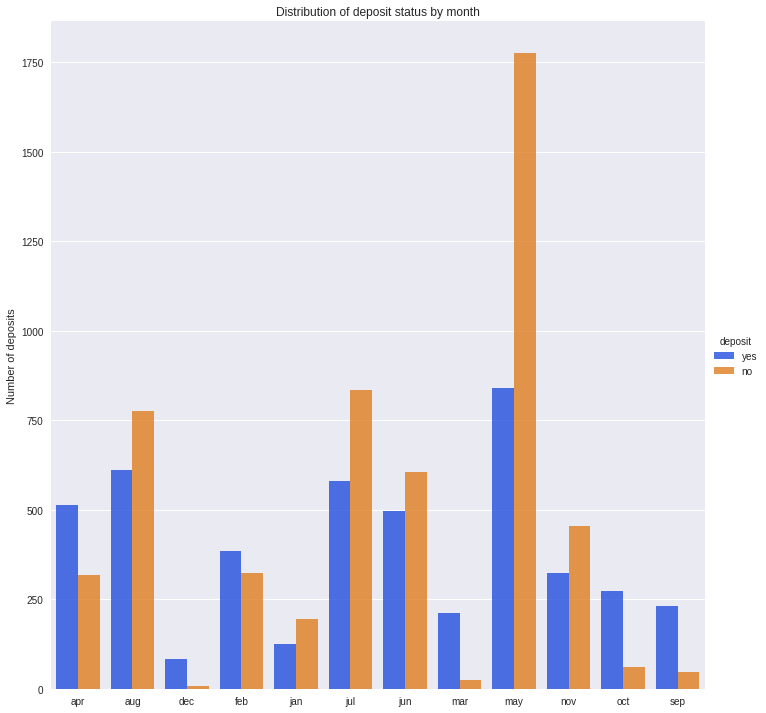

In [80]:
# Find out in which month the offer to open a deposit was most often refused
df_grpd_months = df[[
                    "month", "deposit"
                    ]].groupby("month"
                              ).value_counts().reset_index().rename(
                                                    columns={0:"dep_count"})
months_plot = sns.catplot(
                        data=df_grpd_months, 
                        kind="bar", 
                        x="month", 
                        y="dep_count", 
                        hue="deposit", 
                        palette="bright", 
                        alpha=.8, 
                        height=10
)
months_plot.set(title="Distribution of deposit status by month")
months_plot.set_axis_labels("", "Number of deposits")

The offer to open a deposit was **most often refused in may**

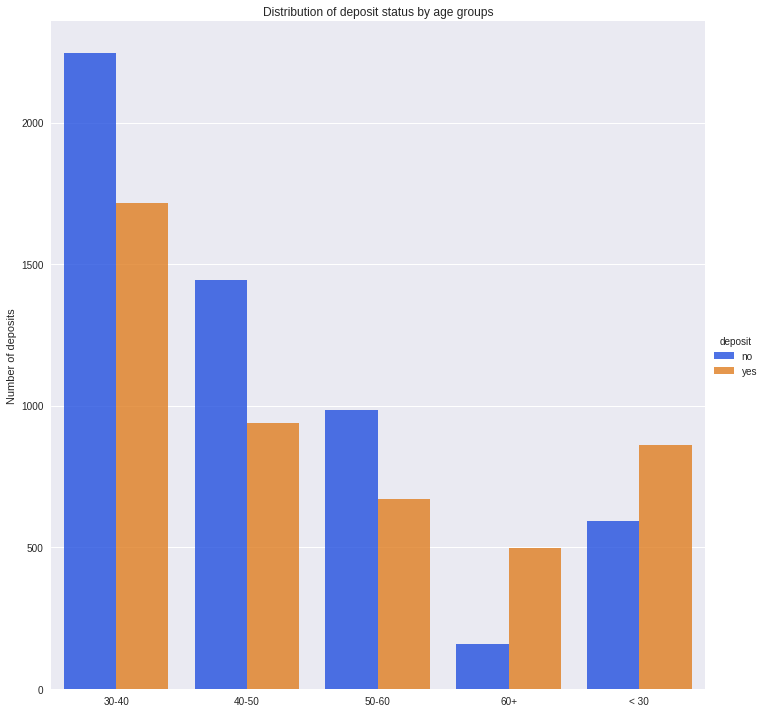

In [81]:
# Create age groups and determine which groups are more likely to open a deposit than to refuse an offer
def age_fix(arg):
    if arg < 30:
        return "< 30"
    if (arg>=30) and (arg < 40):
        return "30-40"
    if (arg>=40) and (arg < 50):
        return "40-50"
    if (arg>=50) and (arg < 60):
        return "50-60"
    if arg >= 60:
        return "60+"
    
df["age"] = df["age"].apply(age_fix)

df_grpd_age = df[[
                "age", "deposit"
                ]].groupby("age"
                          ).value_counts().reset_index().rename(
                                                columns={0:"dep_count"})
age_plot = sns.catplot(
                        data=df_grpd_age, 
                        kind="bar", 
                        x="age", 
                        y="dep_count", 
                        hue="deposit", 
                        palette="bright", 
                        alpha=.8, 
                        height=10
)
age_plot.set(title="Distribution of deposit status by age groups")
age_plot.set_axis_labels("", "Number of deposits")

Groups **older 60 and younger 30** are more likely to open a deposit than to refuse an offer

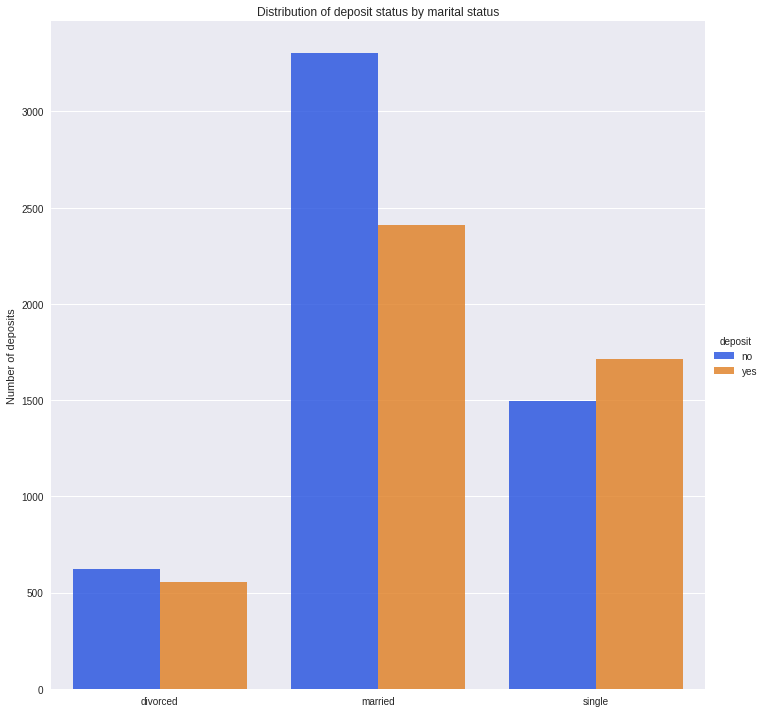

In [82]:
# Plot visualizations for those who have opened and not opened a deposit depending on marital status
df_grpd_marital = df[[
                    "marital", "deposit"
                    ]].groupby("marital"
                              ).value_counts().reset_index().rename(
                                                    columns={0:"dep_count"})
marital_plot = sns.catplot(
                        data=df_grpd_marital, 
                        kind="bar", 
                        x="marital", 
                        y="dep_count", 
                        hue="deposit", 
                        palette="bright", 
                        alpha=.8, 
                        height=10
)
marital_plot.set(title="Distribution of deposit status by marital status")
marital_plot.set_axis_labels("", "Number of deposits")

**Married** clients are more likely to open a deposit than to refuse an offer

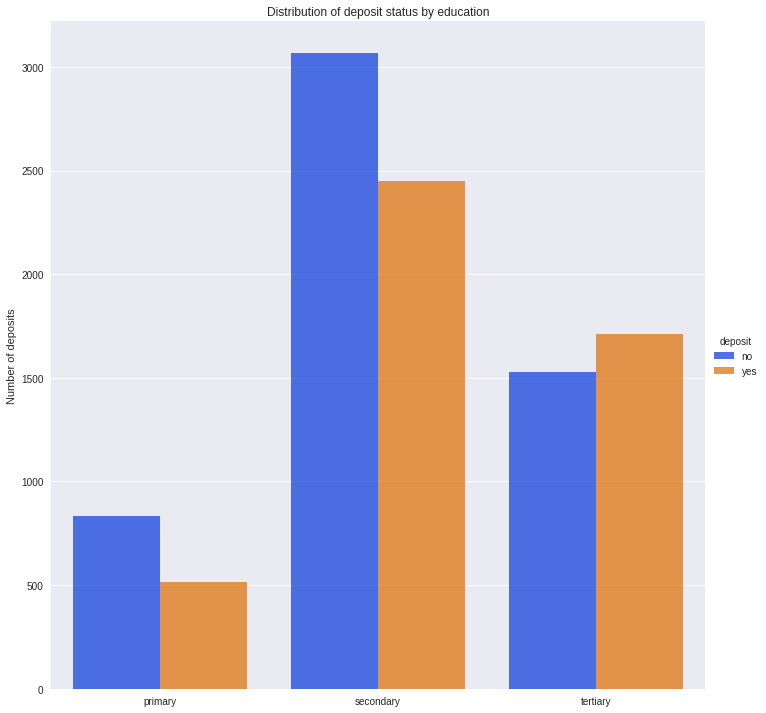

In [83]:
# Plot visualizations for those who have opened and not opened a deposit, depending on the education
df_grpd_education = df[[
                        "education", "deposit"
                        ]].groupby("education"
                                  ).value_counts().reset_index().rename(
                                                        columns={0:"dep_count"})
education_plot = sns.catplot(
                        data=df_grpd_education, 
                        kind="bar", 
                        x="education", 
                        y="dep_count", 
                        hue="deposit", 
                        palette="bright", 
                        alpha=.8, 
                        height=10
)
education_plot.set(title="Distribution of deposit status by education")
education_plot.set_axis_labels("", "Number of deposits")

Clients with **teritary edication** are more likely to open a deposit than to refuse an offer

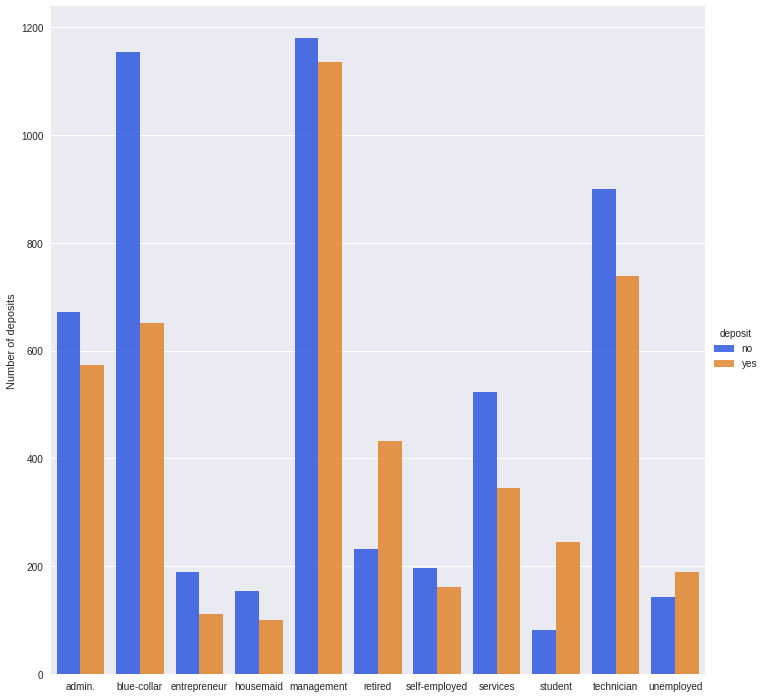

In [84]:
# Plot visualizations for those who have opened and not opened a deposit, depending on the type of professional employment
df_grpd_job = df[[
                "job", "deposit"
                ]].groupby("job"
                          ).value_counts().reset_index().rename(
                                                columns={0:"dep_count"})
job_plot = sns.catplot(
                        data=df_grpd_job, 
                        kind="bar", 
                        x="job", 
                        y="dep_count", 
                        hue="deposit", 
                        palette="bright", 
                        alpha=.8, 
                        height=10
)
marital_plot.set(title="Distribution of deposit status by professional employment")
job_plot.set_axis_labels("", "Number of deposits")

**Retired and unemployed** clients are more likely to open a deposit than to refuse an offer

Text(0.5, 1.0, 'Education and marital distribution without deposit')

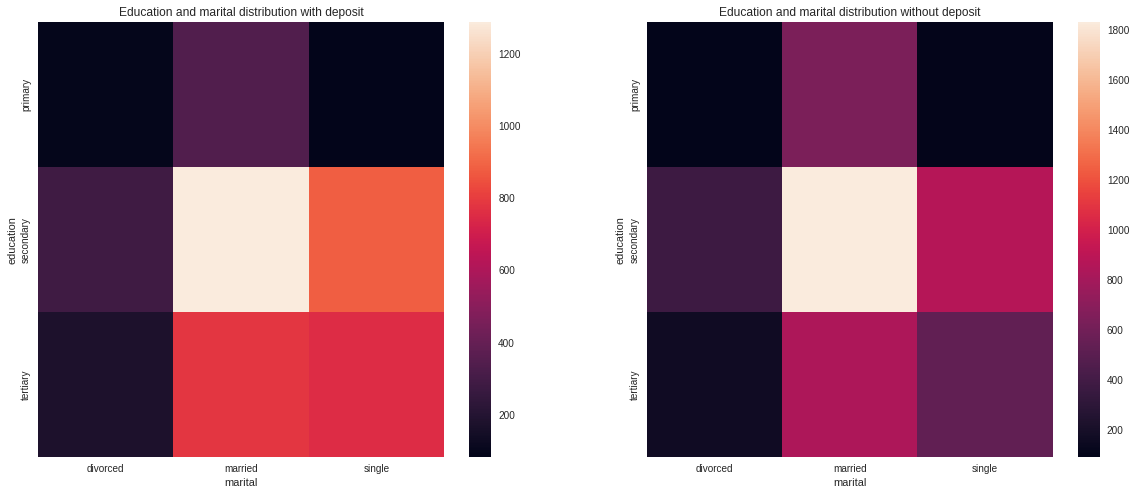

In [85]:
# Plot a pivot table to identify people with what education and marital status are the most numerous
pivot_depo_yes = df[df["deposit"]=="yes"].pivot_table(
    index="education",
    columns="marital",
    values="deposit",
    aggfunc="count"
)
pivot_depo_no = df[df["deposit"]=="no"].pivot_table(
    index="education",
    columns="marital",
    values="deposit",
    aggfunc="count"
)
fig, axes = plt.subplots(1, 2, figsize=(20, 8)) 
sns.heatmap(data=pivot_depo_yes, ax=axes[0])
axes[0].set_title("Education and marital distribution with deposit")
sns.heatmap(data=pivot_depo_no, ax=axes[1])
axes[1].set_title("Education and marital distribution without deposit")

The most numerous people are married and have secondary education which both opened and didn't deposits

## Part 3: Transform Data

In [86]:
# Encode education levels and age with LabelEncoder
label_encoder = LabelEncoder()
df["education"] = label_encoder.fit_transform(df[["education"]])
df["age"] = label_encoder.fit_transform(df[["age"]])

In [87]:
# Encode binary variables with 1 and 0
df["deposit"] = df["deposit"].apply(lambda x: 1 if x=="yes" else 0)
df["default"] = df["default"].apply(lambda x: 1 if x=="yes" else 0)
df["housing"] = df["housing"].apply(lambda x: 1 if x=="yes" else 0)
df["loan"] = df["loan"].apply(lambda x: 1 if x=="yes" else 0)

In [88]:
# OneHotEncoding using get_dummies
df = pd.get_dummies(df, columns=["job", "marital", "contact", "month", "poutcome"])

[Text(0.5, 1.0, 'Correlation matrix')]

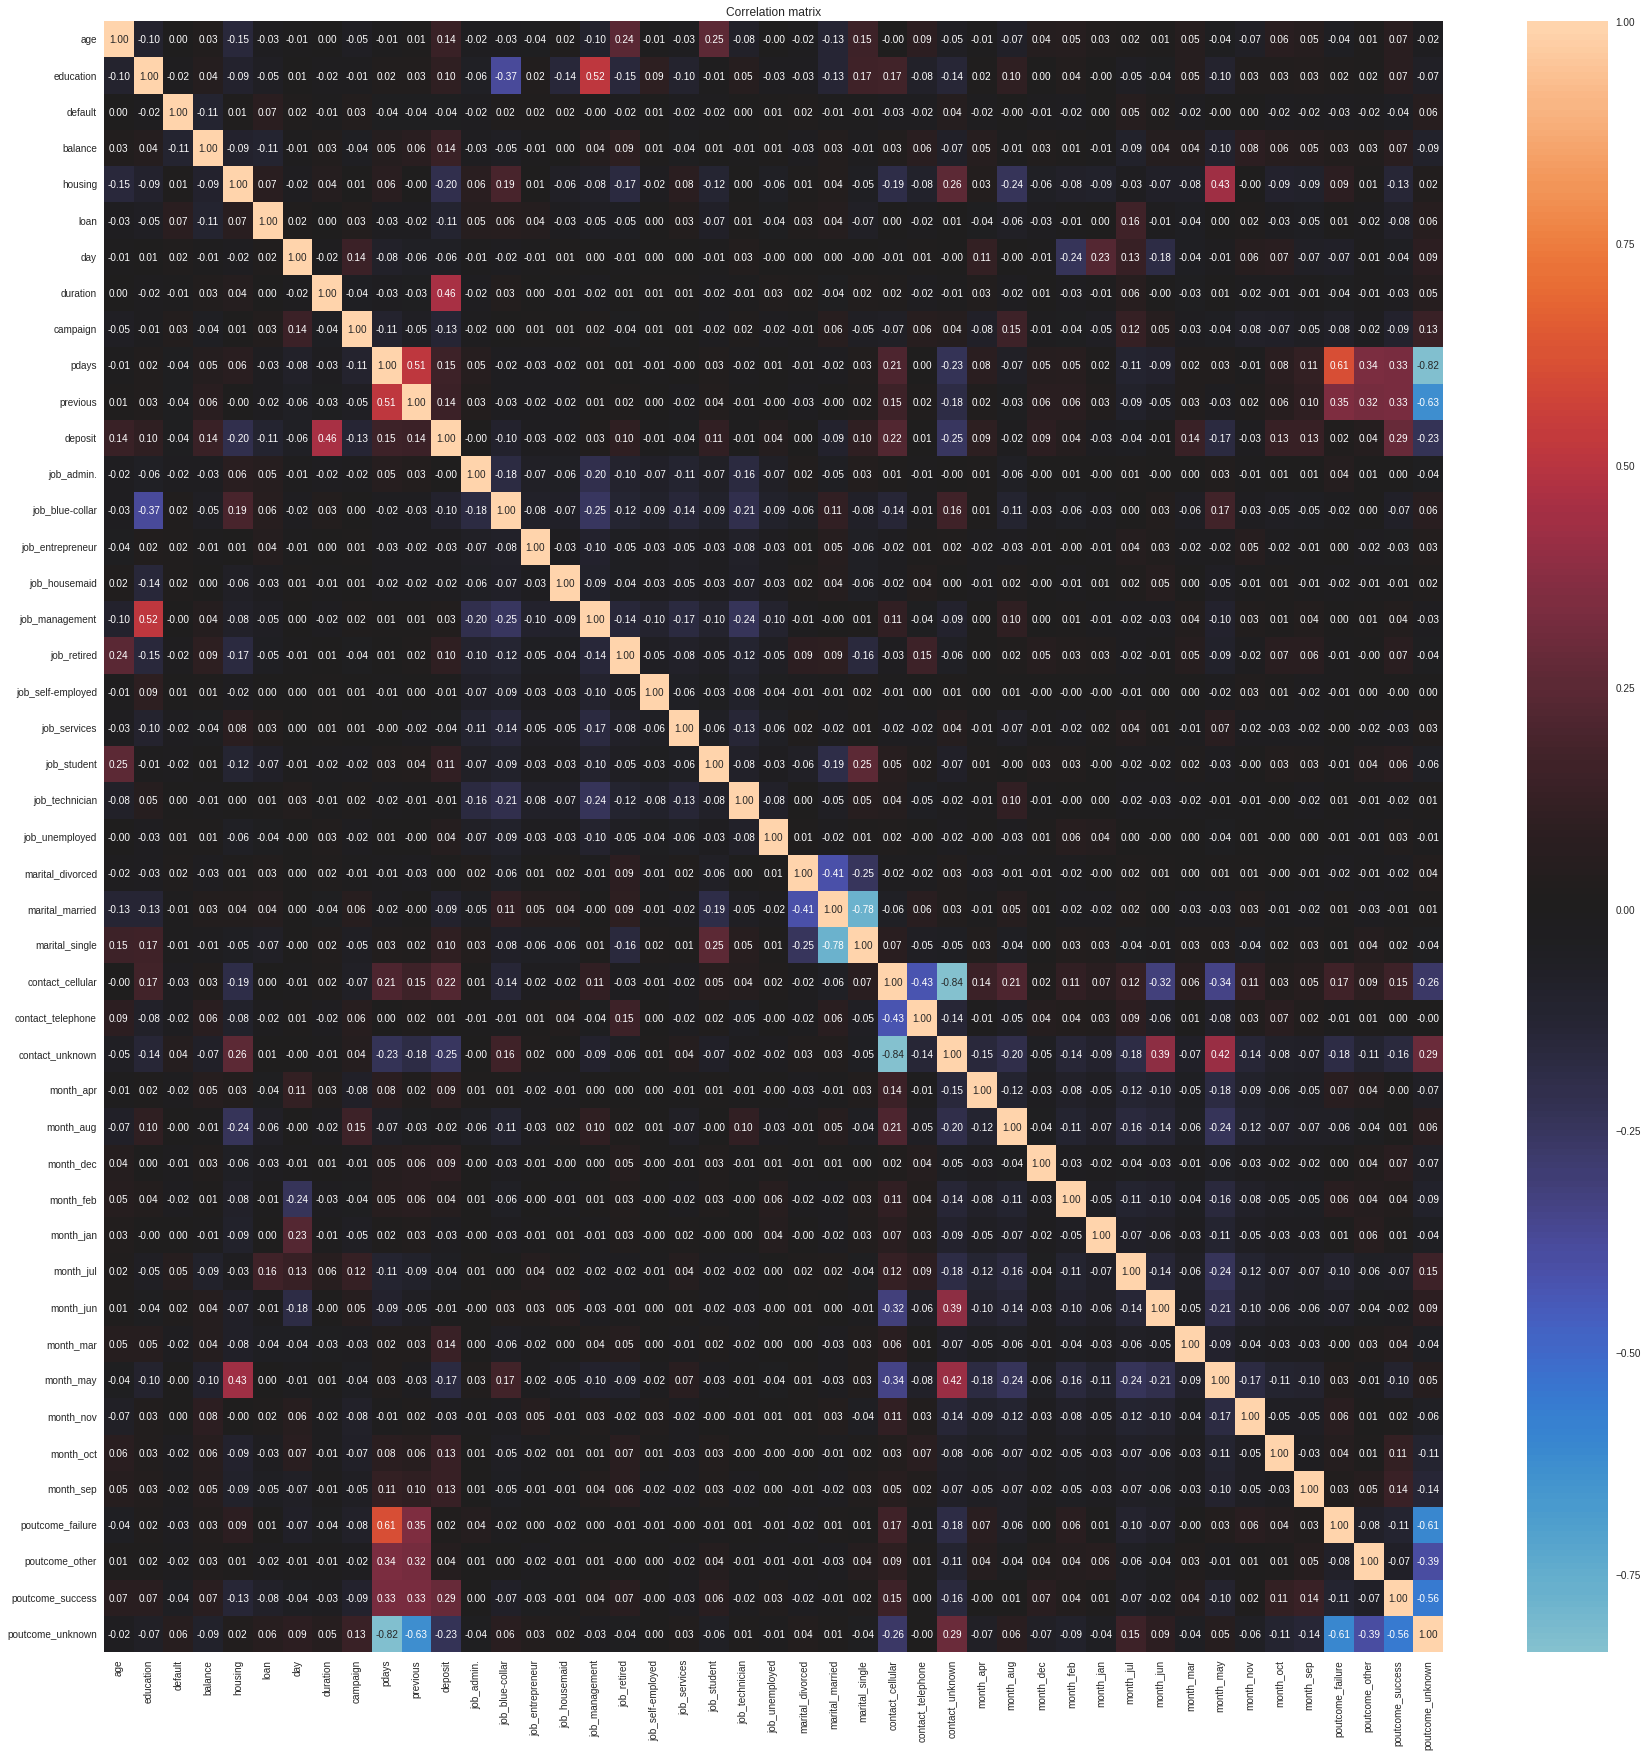

In [89]:
# Plot a correlation matrix and evaluate the data for multicollinearity
# Create a list with numeric features
corr_features = list(df.dtypes[(df.dtypes != "object")].index)
# Get correlation matrix
corr_df = df[corr_features].corr()

plt.figure(figsize=(30,30)) 
sns.heatmap(corr_df, fmt=".2f",annot=True, center=0).set(title="Correlation matrix")

We shall assume that the threshold value is 0.9.<br>
According to our threshold there are no features with multicollinearity

[Text(0.5, 1.0, 'Correlation values of features to target feature')]

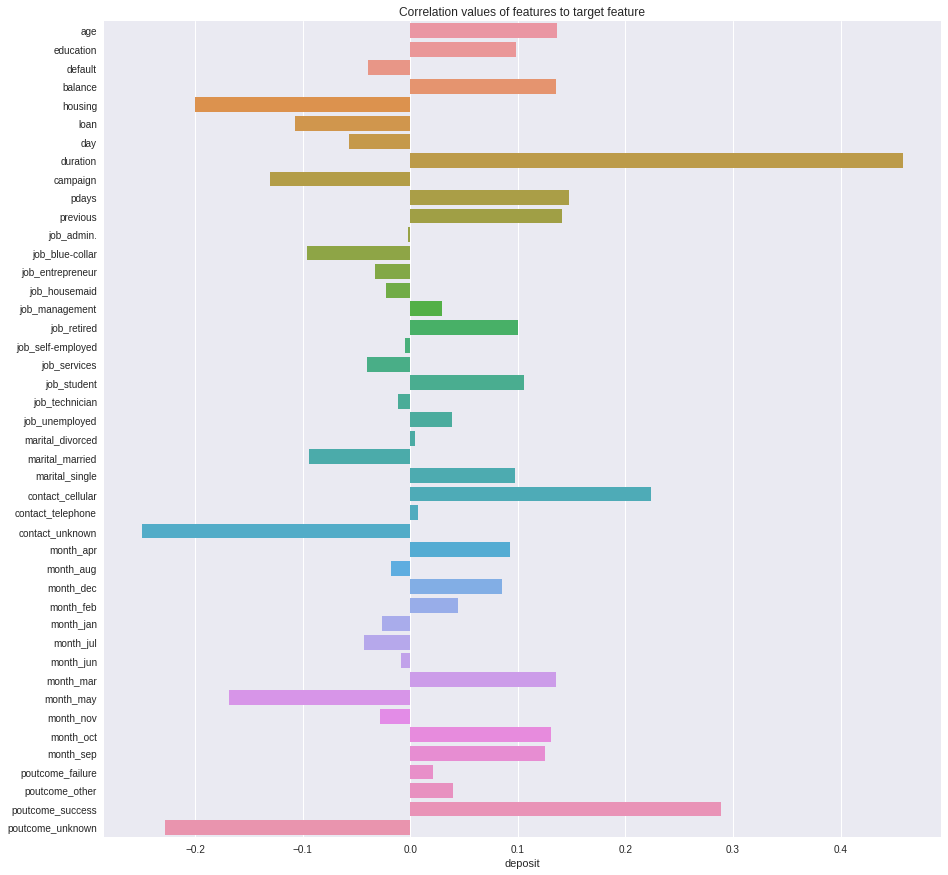

In [90]:
# Plot correlation values of features to target feature
# Delete deposit feature from graph
cols = corr_df.drop("deposit", axis=0).index
vals = corr_df["deposit"].drop("deposit")

plt.figure(figsize=(15,15)) 
sns.barplot(x=vals, y=cols).set(title="Correlation values of features to target feature")

In [92]:
# Split dataset
X = df.drop(["deposit"], axis=1)
y = df["deposit"]
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [94]:
# Shape of test data and share of 1 target feature
print(f"[purple]Size of test part: [green]{X_test.shape}")
print(f"[purple]Mean value of target: [green]{round(df['deposit'].mean(), 2)}")

Size of test part: (3335, 44)

Mean value of target: 0.46

In [95]:
# Use SelectKBest to select the 15 most relevant features
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

# Create list of selected feature names 
list_of_features = list(selector.get_feature_names_out())
print(list_of_features)


[
    'age',
    'balance',
    'housing',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'contact_cellular',
    'contact_unknown',
    'month_mar',
    'month_may',
    'month_oct',
    'month_sep',
    'poutcome_success',
    'poutcome_unknown'
]

In [96]:
# Normalize data with MinMaxScaler
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(X_train[list_of_features])
X_train = pd.DataFrame(x_train_scaled, columns=list_of_features)
# Restore index for train data
X_train.set_index(y_train.index, inplace=True)

x_test_scaled = scaler.transform(X_test[list_of_features])
X_test = pd.DataFrame(x_test_scaled, columns=list_of_features)
# Restore index for test data
X_test.set_index(y_test.index, inplace=True)

# Part 4: Solving the Classification Problem: Logistic Regression and Decision Trees

In [98]:
# Train logistic regression and calculate quality metrics
model_lr = linear_model.LogisticRegression(solver="sag", max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)

y_pred_train = model_lr.predict(X_train)
y_pred_test = model_lr.predict(X_test)

print(
    f"[purple]Accuracy score on train data: \
[green]{np.round(metrics.accuracy_score(y_train, y_pred_train), 3)}"
)
print(
    f"[purple]Accuracy score on test data: \
[green]{np.round(metrics.accuracy_score(y_test, y_pred_test), 3)}"
)
print(metrics.classification_report(y_test, y_pred_test))

Accuracy score on train data: 0.824

Accuracy score on test data: 0.805

precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335

In [99]:
# Train decision trees, tune max depth
model_tree = tree.DecisionTreeClassifier(criterion="entropy", random_state=42, max_depth=6)
model_tree.fit(X_train, y_train)

y_pred_train = model_tree.predict(X_train)
y_pred_test = model_tree.predict(X_test)

print(
    f"[purple]Accuracy score on train data: \
[green]{np.round(metrics.accuracy_score(y_train, y_pred_train), 3)}"
)
print(
    f"[purple]Accuracy score on test data: \
[green]{np.round(metrics.accuracy_score(y_test, y_pred_test), 3)}"
)
print(metrics.classification_report(y_test, y_pred_test))

Accuracy score on train data: 0.819

Accuracy score on test data: 0.809

precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335

In [106]:
# Select the optimal parameters using Grid Search
param_grid = {
              "min_samples_split": [2, 5, 7, 10],
              "max_depth":[3,5,7]
             }

grid_search = GridSearchCV(
    param_grid=param_grid,
    estimator=tree.DecisionTreeClassifier(random_state=42, criterion="entropy"),
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

y_pred_train = grid_search.predict(X_train)
y_pred_test = grid_search.predict(X_test)

print(
    f"[purple]Best accuracy score on train data: \
[green]{np.round(metrics.accuracy_score(y_train, y_pred_train), 3)}"
)
print(
    f"[purple]Best accuracy score on test data: \
[green]{np.round(grid_search.score(X_test, y_test), 3)}"
)
print(f"[purple]Best hyperparameters: [green]{grid_search.best_params_}")
print(metrics.classification_report(y_test, y_pred_test))

Best accuracy score on train data: 0.836

Best accuracy score on test data: 0.818

Best hyperparameters: {'max_depth': 7, 'min_samples_split': 7}

precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

# Part 5: Solving the Classification Problem: Ensembles of models and Prediction

In [105]:
# Train a random forest 
model_rfc = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = "gini",
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)
model_rfc.fit(X_train, y_train)

y_pred_train = model_rfc.predict(X_train)
y_pred_test = model_rfc.predict(X_test) 

print(
    f"[purple]Accuracy for train data: \
[green]{np.round(metrics.accuracy_score(y_train, y_pred_train), 3)}"
)
print(
    f"[purple]Accuracy for test data: \
[green]{np.round(metrics.accuracy_score(y_test, y_pred_test), 3)}"
)
print(metrics.classification_report(y_test, y_pred_test))

Accuracy for train data: 0.856

Accuracy for test data: 0.827

precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

In [107]:
# Use gradient boosting for classification and compare quality with random forest
model_gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
model_gb.fit(X_train, y_train)

y_pred_train = model_gb.predict(X_train)
y_pred_test = model_gb.predict(X_test) 

print(
    f"[purple]Accuracy for train data: \
[green]{np.round(metrics.accuracy_score(y_train, y_pred_train), 3)}"
)
print(
    f"[purple]Accuracy for test data: \
[green]{np.round(metrics.accuracy_score(y_test, y_pred_test), 3)}"
)
print(metrics.classification_report(y_test, y_pred_test))

Accuracy for train data: 0.888

Accuracy for test data: 0.827

precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

In [110]:
# Combine the algorithms you already know using stacking
estimators=[
    ("lr", linear_model.LogisticRegression(
                                        solver="sag", 
                                        max_iter=1000, 
                                        random_state=42
                                        )
     ),
    ("dt", tree.DecisionTreeClassifier(
                                    criterion="entropy", 
                                    random_state=42, 
                                    max_depth=7, 
                                    min_samples_split=7
                                    )
     ),
    ("gb", ensemble.GradientBoostingClassifier(
                                            learning_rate=0.05,
                                            n_estimators=300,
                                            min_samples_leaf=5,
                                            max_depth=5,
                                            random_state=42
                                            )
    )
]

model_stack = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(
                                                max_iter=1000,
                                                random_state=42
                                                )
)
model_stack.fit(X_train, y_train)

y_pred_train = model_stack.predict(X_train)
y_pred_test = model_stack.predict(X_test)

print(
    f"[purple]Accuracy for train data: \
[green]{np.round(metrics.accuracy_score(y_train, y_pred_train), 3)}"
)
print(
    f"[purple]Accuracy for test data: \
[green]{np.round(metrics.accuracy_score(y_test, y_pred_test), 3)}"
)
print(metrics.classification_report(y_test, y_pred_test))

Accuracy for train data: 0.869

Accuracy for test data: 0.821

precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.80      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

<AxesSubplot:>

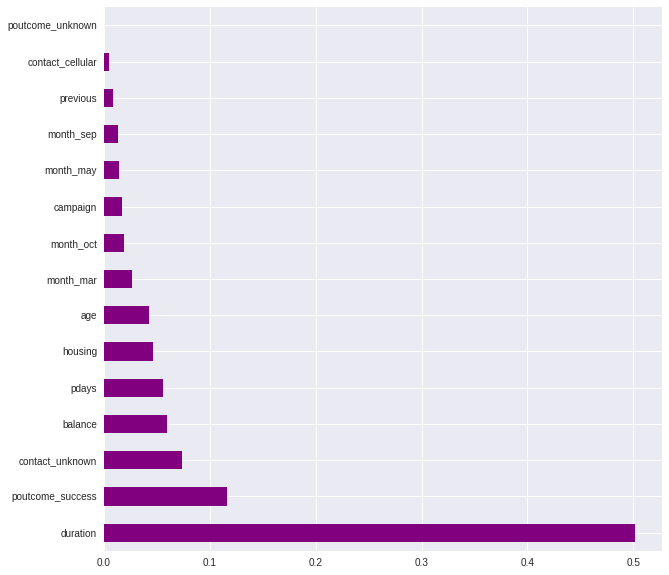

In [111]:
# Evaluate which features show the most importance in the gradient boosting model
plt.rcParams["figure.figsize"] = (10,10)
feat_importances = pd.Series(model_gb.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind="barh", color="purple")

In [112]:
# Implement hyperparameters optimization with Optuna
def optuna_rfc(trial):
  
  # Create space with hyperparameters variants
  n_estimators = trial.suggest_int("n_estimators", 100, 200, 1)
  max_depth = trial.suggest_int("max_depth", 10, 30, 1)
  min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10, 1)

  # Create model
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # Train model
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))
  
  return score
  
  
# Create study objext
# We can directly specify that we need to maximize the metric direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# looking for the best combination of hyperparameters n_trials times
study.optimize(optuna_rfc, n_trials=40)

# Calculate the accuracy for the test sample
model_optuna_rfc = ensemble.RandomForestClassifier(**study.best_params, random_state=42, )
model_optuna_rfc.fit(X_train, y_train)

y_train_pred = model_optuna_rfc.predict(X_train)
y_test_pred = model_optuna_rfc.predict(X_test)

print(
  f"[purple]Accuracy on train data: \
[green]{np.round(metrics.accuracy_score(y_train, y_train_pred), 3)}"
)
print(
  f"[purple]Accuracy on test data: \
[green]{np.round(model_optuna_rfc.score(X_test, y_test), 3)}"
)
print(
  f"[purple]Best hyperparemeters: \
[green]{study.best_params}"
)
print(metrics.classification_report(y_test, y_pred_test))

[I 2022-11-09 02:20:07,540] A new study created in memory with name: RandomForestClassifier
[I 2022-11-09 02:20:08,176] Trial 0 finished with value: 0.848923125294765 and parameters: {'n_estimators': 174, 'max_depth': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.848923125294765.
[I 2022-11-09 02:20:08,872] Trial 1 finished with value: 0.8420059739034743 and parameters: {'n_estimators': 200, 'max_depth': 11, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.848923125294765.
[I 2022-11-09 02:20:09,383] Trial 2 finished with value: 0.856740694401001 and parameters: {'n_estimators': 138, 'max_depth': 22, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.856740694401001.
[I 2022-11-09 02:20:09,817] Trial 3 finished with value: 0.8853074636207166 and parameters: {'n_estimators': 102, 'max_depth': 17, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8853074636207166.
[I 2022-11-09 02:20:10,359] Trial 4 finished with value: 0.8488756093725428 and parameters: {'n_esti

Accuracy on train data: 0.928

Accuracy on test data: 0.825

Best hyperparemeters: {'n_estimators': 125, 'max_depth': 26, 'min_samples_leaf': 2}

precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.80      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

Best results was get with optuna optimization of hyperparameters in Random Forest Classifier:<br>
accuracy on train data: 92.8%<br>
accuracy on test data: 82.5%